In [53]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import scipy.stats
from tqdm import tqdm


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(4))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 8 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [3]:
import open_clip
import clip
from open_clip import tokenizer

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)

clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [4]:
classes = {}
with open("./datasets/cifar10/labels.txt", "r") as f:
    cls_names = f.read().lower().split("\n")

for i, cls_name in enumerate(cls_names):
    classes[i] = cls_name

del classes[10]

print(classes)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# image encodings

In [5]:
path_to_im = "./datasets/cifar10/train"
image_dirs = [path_to_im + "/{}/".format(cls) for cls in classes.values()]
N = 50 
selected_images = []

for dir in image_dirs:
    filenames = os.listdir(dir)
    upd_filenames = [dir + f for f in filenames]
    selected_images.append(sorted(upd_filenames[:N]))

selected_images = [item for sublist in selected_images for item in sublist]

In [7]:
image_inputs = []

for name in tqdm(selected_images):
    im = Image.open(name)
    im_input = preprocess(im).unsqueeze(0).to(device)
    image_inputs.append(im_input)

image_inputs = torch.stack(image_inputs, dim=0)

100%|█████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


In [8]:
image_encodings = []

with torch.no_grad():
    for image in tqdm(image_inputs):
        image_feature = clip_model.encode_image(image)
        image_encodings.append(image_feature)

image_features = torch.stack(image_encodings, dim=0)

100%|█████████████████████████████████████████| 500/500 [00:12<00:00, 40.93it/s]


# text encodings

In [9]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

with open("conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

for concepts

In [10]:
concept_encodings = []

with torch.no_grad():
    for c in tqdm(concepts):
        text_input = clip.tokenize(c).to(device)
        text_feature = clip_model.encode_text(text_input)
        concept_encodings.append(text_feature)

concept_features = torch.stack(concept_encodings, dim=0)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 95.17it/s]


for classes

In [11]:
class_encodings = []

with torch.no_grad():
    for cls in classes.values():
        text_input = clip.tokenize(cls).to(device)
        text_feature = clip_model.encode_text(text_input)
        class_encodings.append(text_feature)

class_features = torch.stack(class_encodings, dim=0)

In [12]:
print(image_features.shape, "\n")
print(concept_features.shape, "\n")
print(class_features.shape)

torch.Size([500, 1, 512]) 

torch.Size([120, 1, 512]) 

torch.Size([10, 1, 512])


# matrices

In [13]:
def similarity(a: torch.Tensor, b: torch.Tensor):
    nom = a @ b.T
    denom = a.norm(dim=-1) * b.norm(dim=-1)
    return nom / denom

def get_dot_prods_matrix(image_features: torch.Tensor, text_features: torch.Tensor):
    matrix = torch.zeros((len(image_features), len(text_features)))
    for i, im_vector in enumerate(image_features):
        for j, text_vector in enumerate(text_features):
            matrix[i][j] = similarity(im_vector, text_vector)

    return matrix

In [14]:
V_matrix = get_dot_prods_matrix(image_features, concept_features)
T_matrix = get_dot_prods_matrix(class_features, concept_features)

print('V_matrix:', V_matrix.shape, "\n")
print('T_matrix:', T_matrix.shape)

V_matrix: torch.Size([500, 120]) 

T_matrix: torch.Size([10, 120])


# draw TSNE

In [22]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

TSNE only for concepts

In [41]:
concept_features_wv = concept_features.squeeze(dim=1).cpu() # to make [120, 512]

In [42]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=50)

word_tsne = tsne.fit_transform(concept_features_wv) #word_vectors
word_tsne = scaler.fit_transform(concept_features_wv) #word_vectors

In [43]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=concepts) #words

figure(id='p1004', ...)

In [46]:
scaler = StandardScaler()

tsne1 = TSNE(n_components=3, learning_rate='auto',
                 init='random', perplexity=50)

word_tsne1 = tsne1.fit_transform(concept_features_wv)
word_tsne1 = scaler.fit_transform(concept_features_wv)
                                 
draw_vectors(word_tsne1[:, 0], word_tsne1[:, 1], color='green', token=concepts)

figure(id='p1049', ...)

TSNE only for images

In [48]:
image_features_iv = image_features.squeeze(dim=1).cpu() # to make [500, 512]

In [54]:
image_names = []
for name in selected_images:
    upd_name = name.split('_')[1].split('.')[0]
    image_names.append(upd_name)

['automobile', 'automobile', 'automobile', 'automobile', 'automobile']

In [55]:
scaler = StandardScaler()

tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=50)

image_tsne = tsne.fit_transform(image_features_iv)
image_tsne = scaler.fit_transform(image_features_iv)
                                 
draw_vectors(image_tsne[:, 0], image_tsne[:, 1], color='red', token=image_names)

figure(id='p1094', ...)

In [56]:
scaler = StandardScaler()

tsne1 = TSNE(n_components=3, learning_rate='auto',
                 init='random', perplexity=50)

image_tsne1 = tsne1.fit_transform(image_features_iv)
image_tsne1 = scaler.fit_transform(image_features_iv)
                                 
draw_vectors(image_tsne1[:, 0], image_tsne1[:, 1], color='red', token=image_names)

figure(id='p1139', ...)

plot a combination of images and concepts in the same space

In [61]:
image_and_concept_names = image_names + concepts

In [63]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, concept_features_wv])
data_to_draw_pca = PCA(n_components=50).fit_transform(data_to_draw)
data_to_draw_tsne = TSNE(n_components=2).fit_transform(data_to_draw_pca)
data_to_draw_tsne = scaler.fit_transform(data_to_draw_tsne)

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color='blue', token=image_and_concept_names)

figure(id='p1229', ...)

In [62]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, concept_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color='blue', token=image_and_concept_names)

figure(id='p1184', ...)

In [65]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, concept_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = ['red'] * len(image_features_iv)
concept_colors = ['green'] * len(concept_features_wv)
colors = image_colors + concept_colors

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=image_and_concept_names)

figure(id='p1274', ...)

and now we will plot TSNE also with classes

In [67]:
class_features_wv = class_features.squeeze(dim=1).cpu()

In [72]:
all_names = image_and_concept_names + list(classes.values())

In [76]:
scaler = StandardScaler()

data_to_draw = torch.vstack([image_features_iv, concept_features_wv, class_features_wv])
tsne = TSNE(n_components=2, learning_rate='auto', 
            init='random', perplexity=50)

data_tsne = tsne.fit_transform(data_to_draw)
data_tsne = scaler.fit_transform(data_to_draw)

image_colors = ['red'] * len(image_features_iv)
concept_colors = ['green'] * len(concept_features_wv)
class_colors = ['blue'] * len(class_features_wv)
colors = image_colors + concept_colors + class_colors

draw_vectors(data_tsne[:, 0], data_tsne[:, 1], color=colors, token=all_names)

figure(id='p1319', ...)

# norm diffs

In [68]:
# image class|slices
# –––––––––––|–––––––––
# airplane   | [:50]
# automobile | [50:100]
# bird       | [100:150]
# cat        | [150:200]
# deer       | [200:250]
# dog        | [250:300]
# frog       | [300:350]
# horse      | [350:400]
# ship       | [400:450]
# truck      | [450:500]

In [67]:
def calculate_mean_norm_diff(V_rows: torch.Tensor, T_matrix: torch.Tensor):
    """
    V_rows: a rows of V_matrix for the same class
    T_matrix: yeap
    return: a dictionary with similarity scores for each class
    """
    scores = {}
    
    for v_row in V_rows:
        for i in range(len(T_matrix)):
            t_row = T_matrix[i]
            sim = similarity(v_row, t_row)
            class_name = classes[i]
            
            if class_name in scores:
                scores[class_name] += sim.item()
            else:
                scores[class_name] = sim.item()
            
    return scores

def generate_slices_for_classes(num_classes, slice_size):
    """
    num_classes: amount of classes in dataset
    slice_size: how many rows does a particular class occupy in V_matrix
    """
    slices = {}
    for i, class_idx in enumerate(classes):
        start = i * slice_size
        end = (i + 1) * slice_size
        slices[classes[class_idx]] = slice(start, end)
    return slices

def draw_similarity_scores(scores_dict, true_class):
    """
    scores_dict: a nested dictionary with similarity scores
    true_class: the true image class for which scores should be plotted
    """
    
    if true_class not in scores_dict:
        print(f"True class '{true_class}' not found in the scores dictionary.")
        return
    
    scores = scores_dict[true_class]
    df = pd.DataFrame(list(scores.items()), columns=['Class', 'Total Similarity Score'])
    
    plt.figure(figsize=(6, 3)) # 12 6
    sns.scatterplot(data=df, x='Class', y='Total Similarity Score')
    plt.title(f"Similarity Scores for True Class: {true_class}")
    plt.xticks(rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Total Similarity Score")
    plt.tight_layout()
    plt.show()

get scores dict

In [49]:
num_classes = len(classes)
slice_size = len(V_matrix) // num_classes
slices = generate_slices_for_classes(num_classes, slice_size)

for class_name, slice_range in slices.items():
    V_rows = V_matrix[slice_range]
    scores = calculate_mean_norm_diff(V_rows, T_matrix)
    scores_dict[class_name] = scores

plot the results of my hypothesis

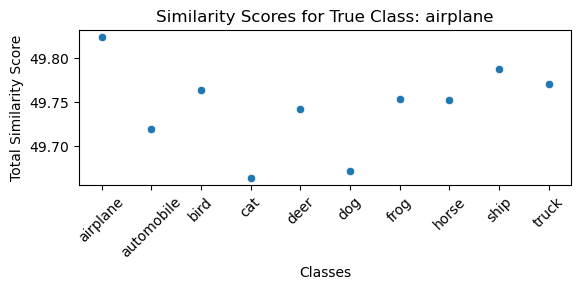

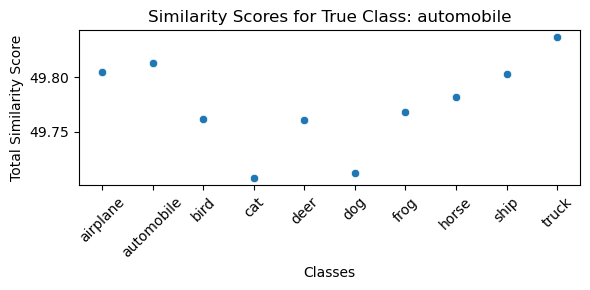

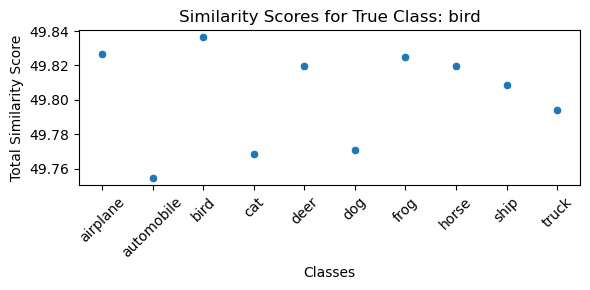

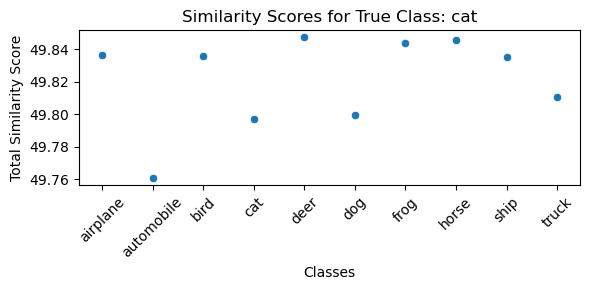

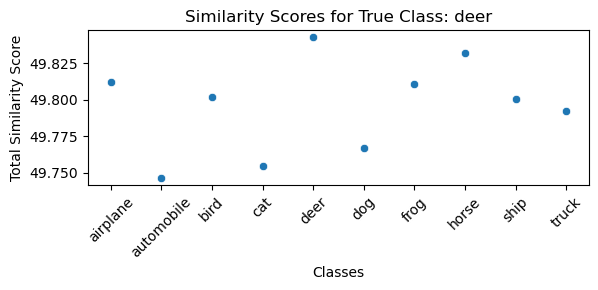

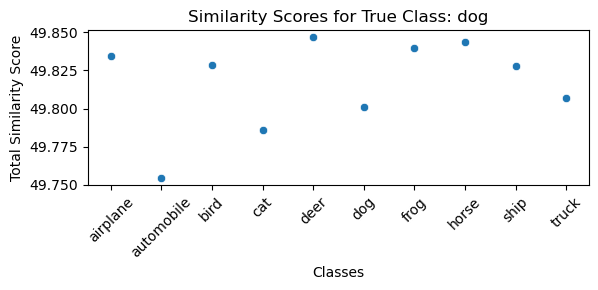

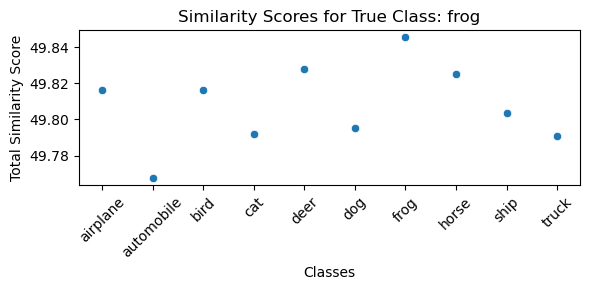

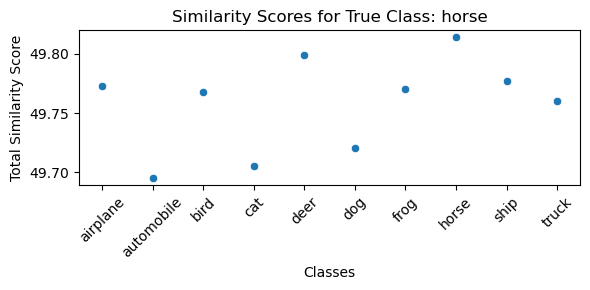

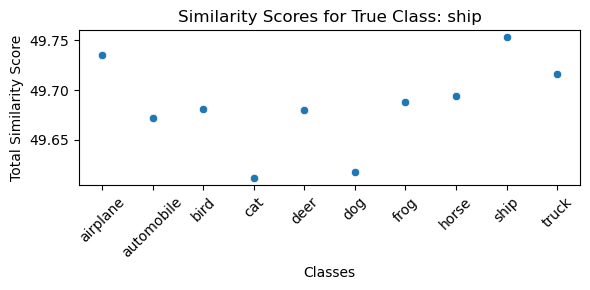

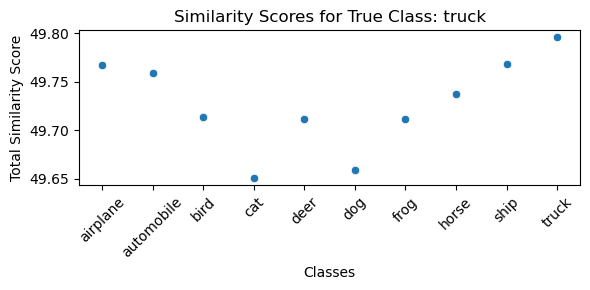

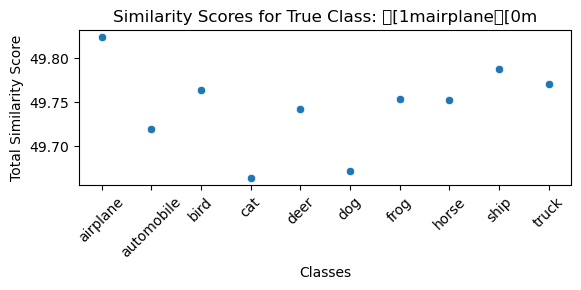

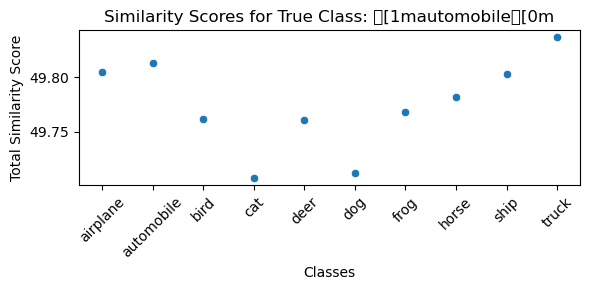

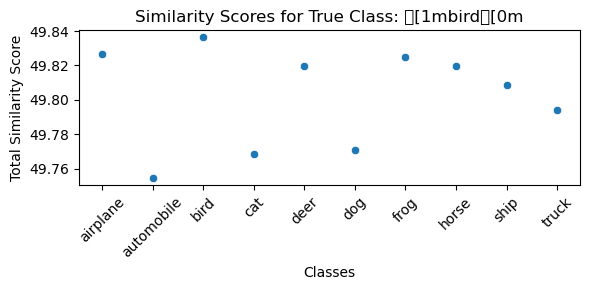

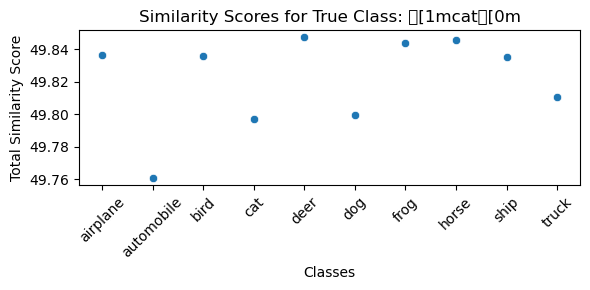

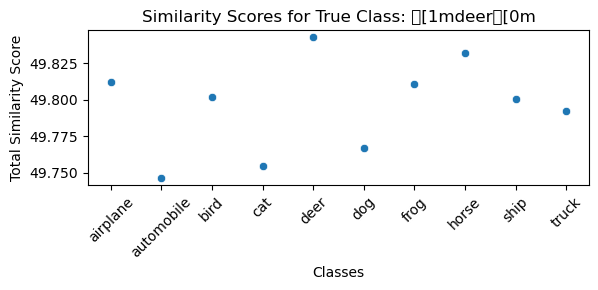

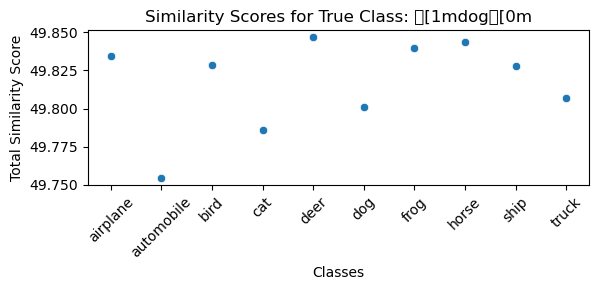

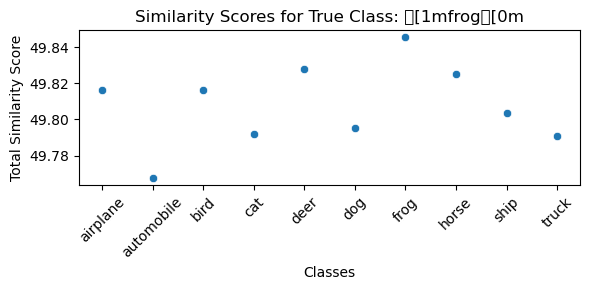

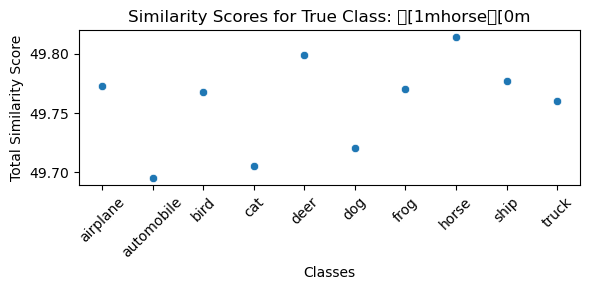

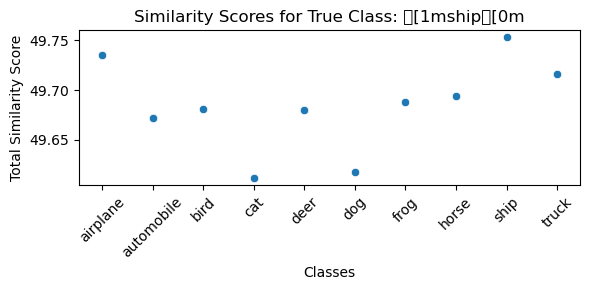

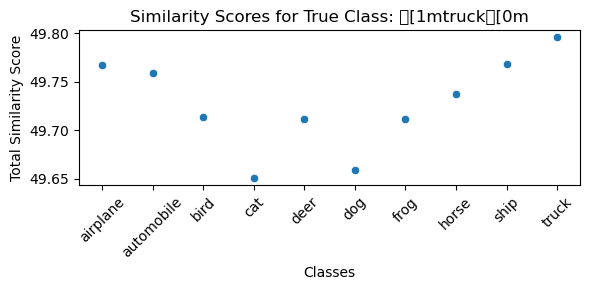

In [68]:
for class_name in scores_dict.keys():
    draw_similarity_scores(scores_dict, class_name)